In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas import read_csv
from pmdarima.arima import auto_arima
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import sklearn.metrics as skmetrics
import warnings
from statsmodels.tsa.stattools import arma_order_select_ic
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import pmdarima as pm

from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

## data reading

In [2]:
data_raw = pd.read_csv('zillow-carlifornia.csv')
data_raw.columns = ['Date', 'MedianSoldPrice', 'MedianMortageRate',
       'UnemploymentRate']
data_raw['Date'] = pd.to_datetime(data_raw['Date'])
data_raw.shape

(107, 4)

In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               107 non-null    datetime64[ns]
 1   MedianSoldPrice    95 non-null     float64       
 2   MedianMortageRate  107 non-null    float64       
 3   UnemploymentRate   107 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 3.5 KB


In [4]:
data = data_raw.loc[~data_raw['MedianSoldPrice'].isna(),:]
data_test = data_raw.loc[data_raw['MedianSoldPrice'].isna(),:]

In [5]:
data_test

,Date,MedianSoldPrice,MedianMortageRate,UnemploymentRate
95,2016-01-31,NaN,3.91,5.0
96,2016-02-29,NaN,3.96,4.9
97,2016-03-31,NaN,3.60,5.0
98,2016-04-30,NaN,3.60,5.0
99,2016-05-31,NaN,3.59,4.8
100,2016-06-30,NaN,3.59,4.8
101,2016-07-31,NaN,3.46,4.9
102,2016-08-31,NaN,3.46,4.8
103,2016-09-30,NaN,3.42,5.0
104,2016-10-31,NaN,3.36,5.0


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 95 to 106
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               12 non-null     datetime64[ns]
 1   MedianSoldPrice    0 non-null      float64       
 2   MedianMortageRate  12 non-null     float64       
 3   UnemploymentRate   12 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 480.0 bytes


In [7]:
data.shape

(95, 4)

In [8]:
print(f'Data Collection Frequency = {np.mean([data.Date[i+1] - data.Date[i] for i in range(len(data)-1)])}')

Data Collection Frequency = 30 days 10:43:24.255319149


## Initial Exploration and Plots

#### Time series Plot, ACF Plot, PACF Plot and ADF Test

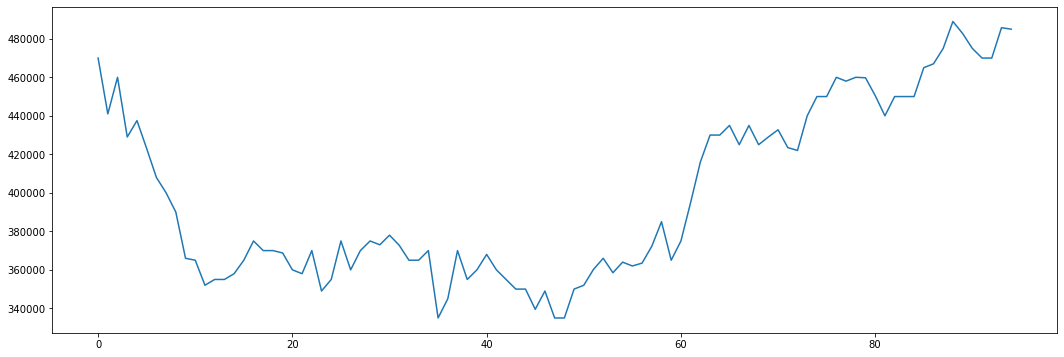

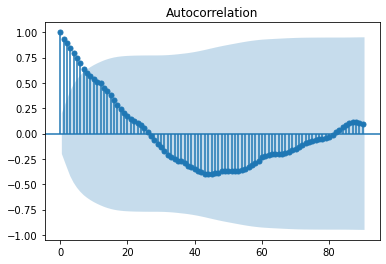

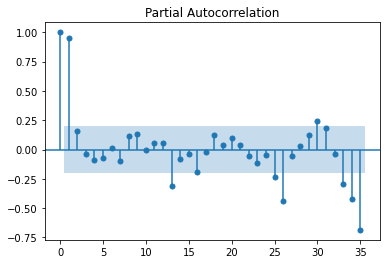

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


In [9]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
ax.plot(data.MedianSoldPrice)
plt.show()
plot_acf(data.MedianSoldPrice,lags=90) 
plt.show()
plot_pacf(data.MedianSoldPrice,lags=35) 
plt.show()

dftest = adfuller(data.MedianSoldPrice)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

### p-value is not less than significant value, so not stationary, needs differencing. No seasonality can be seen. However a seasonality of 12 is assumed for housing prices

# Univariate

### Case 1: Only trend no seasonality

### Candidate 1: Model from Intuition : ARIMA(0,1,1)(0,0,0,0)

#### Differencing

In [10]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

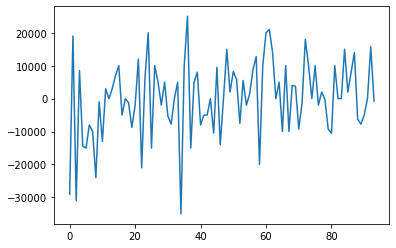

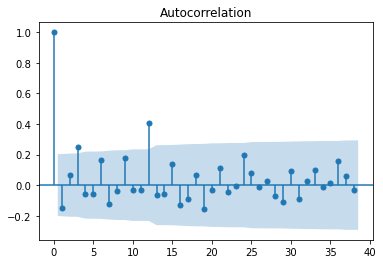

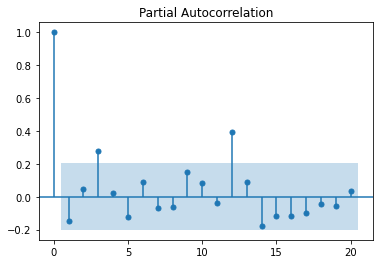

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


In [11]:
d1 = diff(data.MedianSoldPrice, 1)
plt.plot(d1)
plot_acf(d1,lags=38) 
plt.show()
plot_pacf(d1,lags=20) 
plt.show()

dftest = adfuller(d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

#### model_1_1 = ARIMA(0,1,0)(0,0,0)[0]

### Candidate 2: From AIC

In [12]:
model_1_2 = pm.auto_arima(data.MedianSoldPrice, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      m=12,              # seasonal is set to False
                      max_d=2,           # let model determine 'd'
                      seasonal=False,   
                      start_P=0, start_Q=0,
                      max_P=0, max_Q=0,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_1_2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2028.877, Time=1.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2022.609, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2023.514, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2026.900, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2022.030, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2020.308, Time=0.02 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2022.280, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2021.942, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2020.552, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2023.297, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2018.530, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2020.104, Time=0.01 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2020.484, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2020.121, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]          

#### model_1_2 = ARIMA(3,1,0)(0,0,0)[0]

### Candidate 3: From BIC

In [13]:
def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m,D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in tqdm(p_values):
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                    bic = res.bic
                                    if bic < best_score:
                                        best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                except Exception as e:
                                    print(e)
                                    continue
    print((best_score, best_order, best_seasonal_order))

In [14]:
bic_sarima(data.MedianSoldPrice, p_values= range(5), d_values = range(3)
           ,q_values= range(5),P_values=[0],Q_values=[0], m=0, D=0)

100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

(1909.9109890387092, (0, 2, 4), (0, 0, 0, 0))


#### model_1_3 = ARIMA(0, 2, 4),(0, 0, 0)[0]

### Best ARIMA Model Case 1

In [15]:
def evaluate_sarima_model(X, trend_order, seasonal_order, split):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = sm.tsa.statespace.SARIMAX(X[:train_size+t], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
        # calculate out of sample error
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    #mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    return rmse, mape

In [16]:
rmse1, mape1 = evaluate_sarima_model(data.MedianSoldPrice,(0,1,0), (0,0,0,0), 0.67) 
rmse2, mape2 = evaluate_sarima_model(data.MedianSoldPrice,(3,1,0), (0,0,0,0), 0.67)
rmse3, mape3 = evaluate_sarima_model(data.MedianSoldPrice,(0, 2, 4), (0, 0, 0, 0), 0.67)

100%|██████████| 32/32 [00:00<00:00, 32.88it/s]


In [17]:
Case_1_results = pd.DataFrame([[rmse1,mape1],[rmse2, mape2],[rmse3 , mape3]], columns=['rmse','mape'],index=['cand1','cand2', 'cand3'])
Case_1_results

,rmse,mape
cand1,8530.276959,0.014816
cand2,8658.186728,0.015044
cand3,11221.627693,0.020938


#### Best Model for this scenario based on lowest rmse score is candidate 1 ARIMA(0,1,0)(0,0,0,0)

## --------------------------------------------------------------------------------------------------------------

### Case 2: With trend and seasonality

### Candidate 1: Using AIC

In [18]:
model_2_1 = pm.auto_arima(data.MedianSoldPrice, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=7, # maximum p and q
                      m=12,              # seasonal is set to False
                      max_d=2,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=4, max_Q=4,
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_2_1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2028.877, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2023.246, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2024.143, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2026.900, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2022.609, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2023.305, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2023.852, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2022.030, Time=0.02 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2022.601, Time=0.04 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2022.668, Time=0.03 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2022.696, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=2020.308, Time=0.01 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=2020.533, Time=0.05 sec
 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=2020.613, Time=0.04 sec
 ARIMA(3,1,0)(1,0,1

#### model_2_1 = ARIMA(3,1,0)(1,0,1)[12]

### Candidate 2: Using BIC

In [19]:
bic_sarima(data.MedianSoldPrice, p_values= range(4),d_values=range(3)
           ,q_values= range(4),P_values=range(3),Q_values=range(3), m=12, D=1)

100%|██████████| 4/4 [06:52<00:00, 103.04s/it]

(23.933904279385647, (1, 2, 2), (0, 1, 2, 12))


In [20]:
rmse1,mape1 = evaluate_sarima_model(data.MedianSoldPrice,(3,1,0), (1,0,1,12), 0.67)
rmse2,mape2 = evaluate_sarima_model(data.MedianSoldPrice,(1,2,2), (0,1,2,12), 0.67)

100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


In [21]:
Case_2_results = pd.DataFrame([[rmse1,mape1],[rmse2, mape2]], columns=['rmse','mape'],index=['cand1','cand2'])
Case_2_results

,rmse,mape
cand1,8403.884150,0.015245
cand2,14037.253473,0.025920


#### Best Model for this scenario based on lowest rmse score is candidate 1 ARIMA(3,1,0)(1,0,1,12)

### Candidate 3 ETS Models

In [22]:
# define evaluation metrics for model selection based on one-step forward cross validation
def mean_absolute_percentage_error(test, pred):
    return np.mean(np.abs(test-pred)/test)

def evaluate_ets_model(X, trend, seasonality, split, period):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]
    
    predictions = list()
    for t in tqdm(range(len(test))):
        model = ExponentialSmoothing(X[:train_size+t], trend=i, seasonal=j, seasonal_periods=period, 
                                     damped = False if i==None else True)
        model_fit = model.fit()
        yhat = np.asanyarray(model_fit.forecast())[0] #predict one step
        predictions.append(yhat) #store prediction
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test).reshape(-1,)
    try:
        rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
        
    except ValueError:
        rmse = 0
    mape = mean_absolute_percentage_error(test, predictions)
    return rmse, mape

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
trend_ets = ['add', 'mul']
seasonality_ets = ['add', 'mul', None]
metric_ets = {}
for i in trend_ets:
    for j in seasonality_ets:
        print(f'{i}_{j}')
        metric_ets[f'{i}_{j}'] = evaluate_ets_model(data.MedianSoldPrice , i, j, 0.67, 12)

  6%|▋         | 2/32 [00:00<00:02, 12.61it/s]

add_add


  6%|▋         | 2/32 [00:00<00:01, 15.52it/s]

add_mul


 31%|███▏      | 10/32 [00:00<00:00, 91.59it/s]

add_None


  6%|▋         | 2/32 [00:00<00:02, 10.79it/s]

mul_add


  3%|▎         | 1/32 [00:00<00:03,  9.66it/s]

mul_mul


 22%|██▏       | 7/32 [00:00<00:00, 64.32it/s]

mul_None


100%|██████████| 32/32 [00:00<00:00, 60.77it/s]


In [24]:
metric_ets

{'add_add': (12525.597586775266, 0.02232388145324332),
 'add_mul': (42048.53209605236, 0.046716165210892086),
 'add_None': (9915.127918338381, 0.018088846566589562),
 'mul_add': (5.148277936191923e+46, 2.0224345778413309e+40),
 'mul_mul': (11066.603805582812, 0.020265933001436174),
 'mul_None': (9846.88234216811, 0.018000427749011054)}

In [25]:
Case_2_results = pd.DataFrame(metric_ets)
Case_2_results

,add_add,add_mul,add_None,mul_add,mul_mul,mul_None
0,12525.597587,42048.532096,9915.127918,5.148278e+46,11066.603806,9846.882342
1,0.022324,0.046716,0.018089,2.022435e+40,0.020266,0.018000


#### Best Model for this scenario based on lowest rmse score is Trend: Additive  Seasonality: None

### Candidate 4: Prophet models

In [26]:
from prophet import Prophet
train_size = int(len(data) * 0.67)
train, val = data[0:train_size], data[train_size:]
train = train[['Date', 'MedianSoldPrice']].rename(columns={'Date':'ds','MedianSoldPrice':'y'})
val = val[['Date', 'MedianSoldPrice']].rename(columns={'Date':'ds','MedianSoldPrice':'y'})

Importing plotly failed. Interactive plots will not work.


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


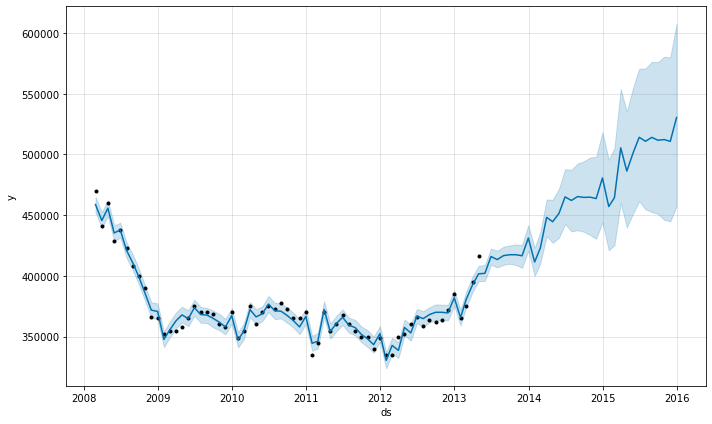

In [27]:
m = Prophet(seasonality_mode='multiplicative').fit(train)
future = m.make_future_dataframe(periods=(len(val)), freq = 'M')
fcst = m.predict(future)
fig = m.plot(fcst)

In [28]:
rmse_val = np.sqrt(skmetrics.mean_squared_error(val['y'], fcst['yhat'][train_size:]))
mape_val = mean_absolute_percentage_error(val['y'], fcst['yhat'][train_size:])

In [29]:
Case_2p_results = pd.DataFrame([[rmse_val,mape_val]], columns=['rmse_val','mape_val'],index=['cand1'])
Case_2p_results

,rmse_val,mape_val
cand1,22482.005808,0.039515


#### Cross validation

In [30]:
from prophet.diagnostics import cross_validation
data_p = data[['Date', 'MedianSoldPrice']].rename(columns={'Date':'ds','MedianSoldPrice':'y'})
# m_1=Prophet(seasonality_mode='multiplicative')
# m_1.fit(data_p)
# initial = f'{int(0.8*len(data_p))-1} days'
# df_cv = cross_validation(m_1, initial=initial, period='1 days', horizon = '30 days')

In [31]:
def evaluate_prophet_model(X, split):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]

    predictions = list()
    for t in tqdm(range(len(test))):
        model_2 = Prophet()
        model_fit = model_2.fit(X[:train_size+t])
        future = model_2.make_future_dataframe(periods=1, freq='M')
        forecast = model_2.predict(future)
        
        yhat = forecast["yhat"][train_size+t:].values #predict one step
        predictions.append(yhat) #store prediction
    
    predictions = np.asarray(predictions).reshape(-1,)
    rmse_val = np.sqrt(skmetrics.mean_squared_error(test.y.values, predictions))
    mape = mean_absolute_percentage_error(test.y.values, predictions)
    return rmse_val,mape

In [32]:
evaluate_prophet_model(data_p, 0.67)

  0%|          | 0/32 [00:00<?, ?it/s]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  3%|▎         | 1/32 [00:01<01:00,  1.95s/it]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  6%|▋         | 2/32 [00:04<01:13,  2.47s/it]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  9%|▉         | 3/32 [00:07<01:11,  2.46s/it]INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 12%|█▎        |

(11513.812961283602, 0.021568281339619744)

We see that as compared to our other candidates models above prophet doesn't perform as well(as verified using RMSE scores)

#### We keep the default prophet model as our candidate

## -----------------------------------------------------------------------------------------------------------

## Case 3: Multivariate with Exogenous

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
def evaluate_sarima_exog_model_scaled(X, exog, trend_order, seasonal_order, split):
    train_size = int(len(X) * split)
    train, test = X[0:train_size], X[train_size:]

    predictions = list()
    sc = MinMaxScaler(feature_range = (0,1))
    for t in tqdm(range(len(test))):
        
        d_sc = sc.fit_transform(X.iloc[:train_size+t,:].values)
        t_sc = sc.transform(X.iloc[train_size+t,:].values.reshape(1,-1))
        model = sm.tsa.statespace.SARIMAX(d_sc[:train_size+t,0], exog = d_sc[:train_size+t, exog:], 
                                          order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time

        model_fit = model.fit()
        yhat = model_fit.forecast(1,exog = t_sc[0,exog:])
        y_pred_ = np.repeat(yhat.reshape(-1,1), 3 if exog == -2 else 2, axis = 1)
        y_pred_inv = sc.inverse_transform(y_pred_)[0,0]
        predictions.append(y_pred_inv)

    test = np.asanyarray(test.values[:,0]).reshape(-1,)
    #mae = skmetrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(skmetrics.mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)
    return rmse, mape

In [35]:
sc = MinMaxScaler(feature_range = (0,1))
data_sc = sc.fit_transform(data.iloc[:,[1,3]].values)
data_sc[:,-1].reshape(-1,1).shape

(95, 1)

### Candidate 1: Exogenous var is UnemploymentRate

In [36]:
sc = MinMaxScaler(feature_range = (0,1))
data_sc = sc.fit_transform(data.iloc[:,[1,3]].values)
model_3_1 = auto_arima(data_sc[:,0], # gdp as endogenous
                 exogenous= data_sc[:,-1:], # rest as exogenous
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=2,
                 m=12, D=1, max_P=3, max_Q=3,
                 trace=True,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)
print(model_3_1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-24.262, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-188.071, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-84.962, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-22.415, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-188.721, Time=0.11 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-189.256, Time=0.34 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-186.903, Time=0.47 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-188.274, Time=1.18 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-25.770, Time=0.11 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-192.196, Time=0.46 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=

#### Candidate 1: ARIMA(2,0,0)(0,1,1)[12] exog = unemployment rate

### Candidate 2: Exogenous var is Morgage rate

In [37]:
sc = MinMaxScaler(feature_range = (0,1))
data_sc = sc.fit_transform(data.iloc[:,[1,2]].values)
model_3_2 = auto_arima(data_sc[:,0], # gdp as endogenous
                 exogenous= data_sc[:,-1:], # rest as exogenous
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=2,
                 m=12, D=None, max_P=3, max_Q=3,
                 trace=True,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)


print(model_3_2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-159.896, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-140.790, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-211.849, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-230.335, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=-210.835, Time=0.04 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=-233.004, Time=0.28 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-234.985, Time=0.13 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=-232.998, Time=0.45 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=-231.000, Time=0.53 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-161.412, Time=0.10 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-242.299, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=-213.215, Time=0.05 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=-240.631, Time=0.53 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=-241.110, Time=0.27 sec
 ARIMA(1,2,1)(0,0,1

#### Candidate 2 ARIMA(1,2,1)(1,0,0)[12] exog var = mortgage rate

### Candidate 3: Both Exogenous var

In [38]:
sc = MinMaxScaler(feature_range = (0,1))
data_sc = sc.fit_transform(data.iloc[:,[1,2,3]].values)
model_3_3 = auto_arima(data_sc[:,0],
                       # gdp as endogenous
                 exogenous= data_sc[:,-2:], # rest as exogenous
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=2,
                 m=12, D=1, max_P=3, max_Q=3,
                 trace=True,
                 error_action='ignore', 
                 suppress_warnings=True,information_criterion='oob', n_jobs = -1)
print(model_3_3.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-34.583, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-189.121, Time=0.54 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-90.183, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-24.494, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-189.483, Time=0.24 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-190.247, Time=0.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-186.482, Time=0.55 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-192.175, Time=1.56 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=-189.177, Time=1.52 sec
 ARIMA(1,0,0)(0,1,3)[12] intercept   : AIC=-190.061, Time=2.64 sec
 ARIMA(1,0,0)(1,1,3)[12] intercept   : AIC=inf, Time=3.96 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC

#### Candidate Model 3: ARIMA(1,0,0)(0,1,2)[12]

In [39]:
rmse1, mape1 = evaluate_sarima_exog_model_scaled(data.iloc[:,[1,3]],-1, (2,0,0), (0,1,1,12), 0.67)
rmse2, mape2 = evaluate_sarima_exog_model_scaled(data.iloc[:,[1,2]],-1, (1,2,1), (1,0,0,12), 0.67)
rmse3, mape3 = evaluate_sarima_exog_model_scaled(data.iloc[:,[1,2,3]],-2, (1,0,0), (0,1,2,12), 0.67)
rmse4, mape4 = evaluate_sarima_exog_model_scaled(data.iloc[:,[1,2,3]],-2, (0,2,1), (1,1,1,12), 0.67)

100%|██████████| 32/32 [00:17<00:00,  1.82it/s]


In [40]:
Case_3_results = pd.DataFrame([[rmse1,mape1],[rmse2, mape2],[rmse3 , mape3],[rmse4 , mape4]], columns=['rmse','mape'],index=['cand1','cand2', 'cand3', 'no_seasonality_cand'])
Case_3_results

,rmse,mape
cand1,8926.671155,0.016712
cand2,9274.272859,0.016436
cand3,9786.038876,0.017819
no_seasonality_cand,11209.957639,0.020857


Tried BIC as information criterion in auto_arima, getting same results for best models

### Candidate 3: all three Exogenous var cases using BIC sarima

In [41]:
def bic_sarima_exog(data, exog, p_values,d_values,q_values,P_values,Q_values,m,D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in tqdm(p_values):
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    res = sm.tsa.statespace.SARIMAX(data,exog = exog,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                    bic = res.bic
                                    if bic < best_score:
                                        best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                except Exception as e:
                                    print(e)
                                    continue
    print((best_score, best_order, best_seasonal_order))

In [42]:
sc = MinMaxScaler(feature_range = (0,1))
data_sc = sc.fit_transform(data.iloc[:,[1,2,3]].values)

bic_sarima_exog(data_sc[:,0],data_sc[:,-2:], p_values= range(3), d_values = range(2)
           ,q_values= range(3),P_values=[0,1,2],Q_values=[0,1,2], m=12, D=1)

100%|██████████| 3/3 [02:39<00:00, 53.09s/it]

(-199.64914624099015, (1, 1, 2), (0, 1, 0, 12))


In [43]:
sc = MinMaxScaler(feature_range = (0,1))
data_sc = sc.fit_transform(data.iloc[:,[1,2]].values)

bic_sarima_exog(data_sc[:,0],data_sc[:,-1:], p_values= range(3), d_values = range(2)
           ,q_values= range(3),P_values=[0,1,2],Q_values=[0,1,2], m=12, D=1)

100%|██████████| 3/3 [02:18<00:00, 46.15s/it]

(-200.38662397449795, (1, 1, 2), (0, 1, 0, 12))


In [44]:
sc = MinMaxScaler(feature_range = (0,1))
data_sc = sc.fit_transform(data.iloc[:,[1,3]].values)

bic_sarima_exog(data_sc[:,0],data_sc[:,-1:], p_values= range(3), d_values = range(2)
           ,q_values= range(3),P_values=[0,1,2],Q_values=[0,1,2], m=12, D=1)

100%|██████████| 3/3 [02:25<00:00, 48.55s/it]

(-200.81669266096318, (1, 1, 2), (0, 1, 0, 12))


In [45]:
rmse6, mape6 = evaluate_sarima_exog_model_scaled(data.iloc[:,[1,3]],-1, (1,1,2), (0,1,0,12), 0.67)
rmse7, mape7 = evaluate_sarima_exog_model_scaled(data.iloc[:,[1,2]],-1, (1,1,2), (0,1,0,12), 0.67)
rmse8, mape8 = evaluate_sarima_exog_model_scaled(data.iloc[:,[1,2,3]],-2, (1,1,2), (0,1,0,12), 0.67)

100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


#### Candidate Model 4: ARIMA(1,1,2)(0,1,0)[12]

In [46]:
Case_3_results_bic = pd.DataFrame([[rmse6,mape6],[rmse7, mape7],[rmse8 , mape8]], 
                                  columns=['rmse','mape'],
                                  index=['cand1_bic','cand2_bic', 'cand3_bic'])
Case_3_results_bic

,rmse,mape
cand1_bic,10782.965502,0.018525
cand2_bic,11072.701641,0.019188
cand3_bic,10667.319981,0.017806


### Best Model = 
### SARIMAX cand	(2,0,0), (0,1,1,12) 8927.39, Exogenous: UnEmployment


## --------------------------------------------------------------------------------------------------------------

# Predictions

In [47]:
data_test = pd.read_csv('test.csv')

In [48]:
data_test = pd.read_csv('test.csv')
data_test['MedianMortageRate'] = data_raw['MedianMortageRate'][95:].values
data_test['UnemploymentRate'] = data_raw['UnemploymentRate'][95:].values
data_test.columns = ['Date', 'MedianSoldPrice', 'MedianMortageRate',
       'UnemploymentRate']

In [49]:
data_test['Date'] =  pd.to_datetime(data_test['Date'])

In [50]:
data_test

,Date,MedianSoldPrice,MedianMortageRate,UnemploymentRate
0,2016-01-31,476250,3.91,5.0
1,2016-02-29,466000,3.96,4.9
2,2016-03-31,485000,3.60,5.0
3,2016-04-30,501000,3.60,5.0
4,2016-05-31,501000,3.59,4.8
5,2016-06-30,505000,3.59,4.8
6,2016-07-31,507000,3.46,4.9
7,2016-08-31,510000,3.46,4.8
8,2016-09-30,510000,3.42,5.0
9,2016-10-31,523000,3.36,5.0


### SARIMAX

In [51]:
def Sarimax_pred(data, ind, data_test, ex, trend_order, seasonal_order):
    sc = MinMaxScaler(feature_range = (0,1))
    data_sc = sc.fit_transform(data.iloc[:,ind].values)
    test_sc = sc.transform(data_test.iloc[:,ind].values)
    
    model = sm.tsa.statespace.SARIMAX(data_sc[:,0], exog = data_sc[:, ex:], 
                                          order=trend_order,seasonal_order=seasonal_order)
    
    model_fit = model.fit()
    yhat = model_fit.forecast(test_sc.shape[0],exog = test_sc[:,ex:])
    y_pred_ = np.repeat(yhat.reshape(-1,1), 3 if ex == -2 else 2, axis = 1)
    y_pred_inv = sc.inverse_transform(y_pred_)[:,0]
    print(y_pred_inv)

    y_pred_series = pd.Series(y_pred_inv,index=data_test.index)
    plt.figure(figsize=(30, 10))
    print(data_test.MedianSoldPrice)

    plt.plot(data_test.MedianSoldPrice, label='actual')
    plt.plot(y_pred_series, label='SARIMAX forecast')
    plt.legend(loc='upper left', fontsize=20)
    plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
    plt.show()
    
    rmse_f = np.sqrt(skmetrics.mean_squared_error(data_test.MedianSoldPrice, y_pred_series))
    mape_f = mean_absolute_percentage_error(data_test.MedianSoldPrice, y_pred_series)
    return y_pred_series,rmse_f, mape_f
    
    

[481064.50351577 480560.78276618 497542.35059645 502661.31190804
 508523.64090192 519169.40120235 516371.34042941 510063.90674414
 508081.31499908 506422.93346952 513073.77518195 515049.84303582]
0     476250
1     466000
2     485000
3     501000
4     501000
5     505000
6     507000
7     510000
8     510000
9     523000
10    506000
11    510000
Name: MedianSoldPrice, dtype: int64


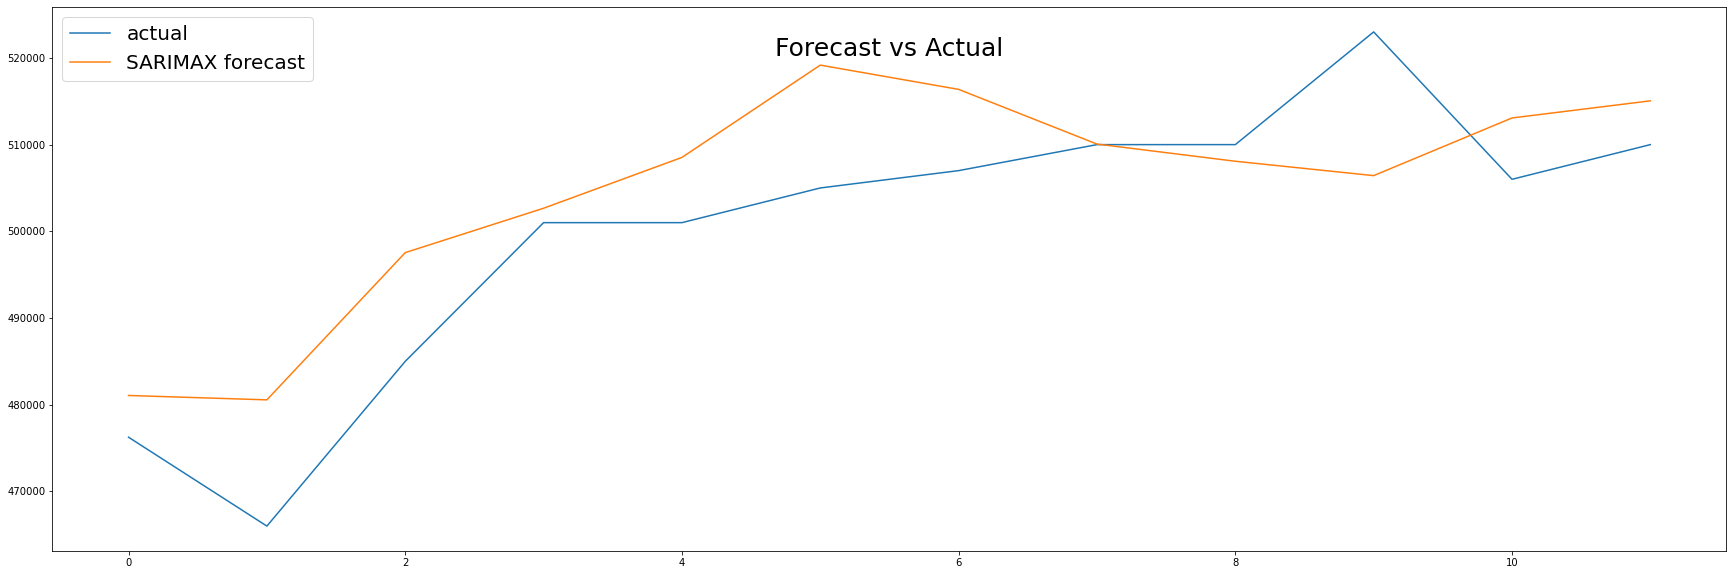

(9550.25854744779, 0.0159630319551259)

In [52]:
preds,rmse_test1, mape_test1 = Sarimax_pred(data, [1,3], data_test, -1, (2,0,0), (0,1,1,12))
rmse_test1, mape_test1

In [53]:
data=data.set_index('Date')

In [54]:
data_test=data_test.set_index('Date')

In [55]:
pred1=pd.Series(preds)
pred1.index = data_test.index
pred1

Date
2016-01-31    481064.503516
2016-02-29    480560.782766
2016-03-31    497542.350596
2016-04-30    502661.311908
2016-05-31    508523.640902
2016-06-30    519169.401202
2016-07-31    516371.340429
2016-08-31    510063.906744
2016-09-30    508081.314999
2016-10-31    506422.933470
2016-11-30    513073.775182
2016-12-31    515049.843036
dtype: float64

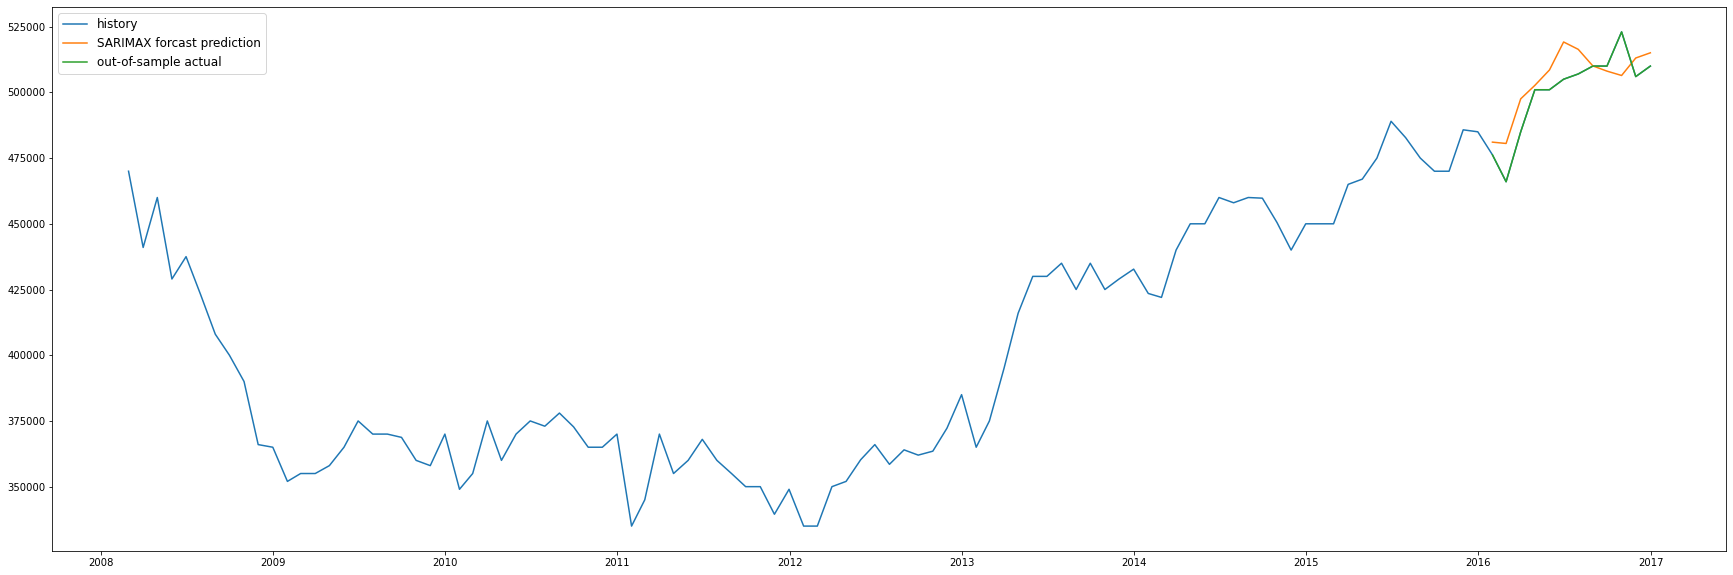

In [65]:
fig = plt.figure(figsize=(30, 10))
plt.plot(pd.concat([data.MedianSoldPrice,data_test.MedianSoldPrice]), label='history')
plt.plot(pred1, label='SARIMAX forcast prediction')
plt.plot(data_test.MedianSoldPrice, label='out-of-sample actual')
plt.legend(loc='upper left', fontsize=12)
plt.show()